In [16]:
# Author: Abhishek Nayak
# from re import S
import sys
sys.path.append('DubinsLineSegToLineSeg/')

from graphutils import is_path_exists, is_route_continuous, is_feasible_path, is_angle_matching, get_shortest_path
from graphutils import ConstructGates, ConnectGates_Dubins, GraphUpdate_BreakGate, UpdatePath_Dubins, GraphUpdate_BreakAngle
from graphutils import ConnectGates_Euclidean, UpdatePath_Euclidean, EuclideanToDubinsGraph
from graphutils import PlotGstar
from graphutils import Graph_Gstar
from DubinsLineSegToLineSeg import DubinsL2L
from map_utils import Map
from copy import deepcopy
import pickle as pkl
import dubins as du
import time
import networkx as nx
import numpy as np
import csv
import os
import yaml
import logging

from networkx.algorithms.shortest_paths.generic import shortest_path
# from networkx.classes.graph import Graph
sys.path.append('DubinsLineSegToLineSeg/')

step_size = 0.1
bound_resolution = 1


def GstarPaths(Map, G, timeLimit, imgPath, heading_restricted, headingAngles):

    '''
    This function computes the Euclidean and Dubins lower and upper bounds of the shortest path
    between the start and goal points in the input Map. If the shortest path is feasible, the
    function terminates. Otherwise, it constructs and connects gates to update the graph and
    continues the computation until the shortest path is feasible or the time limit is reached.

    Args:
    - Map: An object of the Map class, containing the obstacles and start and goal points
    - G: An object of the Graph class, containing the nodes and edges of the graph
    - timeLimit: The maximum computation time allowed for finding the shortest path
    - imgPath: The path where the images of the computed paths will be saved
    - heading_restricted: A boolean indicating whether the heading angles at the start and goal
                          points are restricted or not
    - headingAngles: A dictionary containing the restricted heading angles at the start and goal
                     points (if any)

    Returns:
        A tuple containing the lower bounds of the G* algorithm, the map object, and the GStarGraph object.
    '''

    # Compute the Euclidean upper bound of the shortest path
    eucBoundStartTime = time.monotonic()
    short_path_list, G.eucLB_free = get_shortest_path('s', 'e', G)

    if heading_restricted:
        outAngle = headingAngles['startAngle']*np.pi/180
        inAngle = headingAngles['goalAngle']*np.pi/180
    else:
        outAngle, inAngle = 0, 0

    # Compute the Dubins upper bound of the shortest path
    delta = 0.001
    dubLB_free = DubinsL2L.Line2LineDubins(G.LineStart, (outAngle-delta, outAngle+delta), G.LineEnd, (inAngle-delta, inAngle+delta), G.rho)
    G.dubLB_free, minPath = dubLB_free.MinDub_L2L()

    # Print the Euclidean and Dubins upper bounds
    print("Euclidean Upper Bound (No Obstacles): ", G.eucLB_free)
    print("Dubins Upper Bound (No Obstacles): ", G.dubLB_free)

    ''' Step 1: Construct Euclidean Lower bounds '''
    if not is_feasible_path(short_path_list, G, Map.ObstacleList):
        improve_bounds = True
    else:
        improve_bounds = False

    print('### Solving Euclidean Lower Bound ###')
    loop = 0
    G.eucLB_time, eucBoundStartTime = 0, time.monotonic()
    improve_bounds = True
    
    while improve_bounds and (G.eucLB_time < 0.001*timeLimit):
        path_exists = is_path_exists('s', 'e', G)
        path_feasible = is_feasible_path(short_path_list, G, Map.ObstacleList)
        path_continuous = is_route_continuous(short_path_list, G)

        if path_exists and path_continuous and path_feasible:
            improve_bounds = False
        else:
            if not path_feasible:
                G = ConstructGates(G, Map, short_path_list,graphType='Euclidean')
                G = ConnectGates_Euclidean(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)

            if not path_continuous:
                G = GraphUpdate_BreakGate(G, short_path_list)
                G = UpdatePath_Euclidean(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
        
        print('Path: ', short_path_list)
        G.eucLB_time = time.monotonic()-eucBoundStartTime
        loop += 1
        plotTitle = "Euclidean Lower Bound (length = " + str(round(short_path_length, 3)) + ")"
        PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath+'/step_'+str(loop)+'_euc', action='save')

    G.eucLowerPath, G.eucLowerBound = short_path_list, short_path_length
    G.eucGraph = deepcopy(G.graph)

    print(nx.info(G.graph))
    print('Euclidean Lower Bound: ', G.eucLowerBound)
    print("Time (Euclindean Lower Bound): ", G.eucLB_time)
    plotTitle = "Euclidean Lower Bound (length = " + str(round(G.eucLowerBound, 3)) + ")"
    PlotGstar(G.eucLowerPath, G, Map, plotTitle, save_path=imgPath+'/eucLB', action='save')

    """ Step 2:  Compute Dubins Lower Bound """
    print('### Solving Dubins Lower Bound ###')
    times, Gstar_path_lengths = [], []
    dubBoundStartTime = time.monotonic()
    improve_bounds = True

    G = EuclideanToDubinsGraph(G, heading_restricted, startAngle=outAngle, goalAngle=inAngle)
    G = ConnectGates_Dubins(G)

    short_path_list, short_path_length = get_shortest_path('s', 'e', G)
    times.append(time.monotonic() - dubBoundStartTime)
    Gstar_path_lengths.append(short_path_length)
    loop += 1
    
    plotTitle = "G* (length = " + str(round(short_path_length, 3)) + ")"
    PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath +'/step_'+str(loop)+'_dub', action='save')

    print(short_path_list)
    print('G* lower bound distance: ', short_path_length)
    # PlotGstar(short_path_list, G.graph, self.Map, loop, title)
    G.dubLB_time = time.monotonic()-dubBoundStartTime

    '''### G* lower bounds ###'''
    '''### REPLACE EUCLIDEAN PATHS WITH DubLineToLine ###'''
    while improve_bounds and (G.dubLB_time < timeLimit):
        path_exists = is_path_exists('s', 'e', G)
        path_feasible = is_feasible_path(short_path_list, G, Map.ObstacleList)
        path_continuous = is_route_continuous(short_path_list, G)
        angle_matching = is_angle_matching(short_path_list, G)

        if path_exists and path_continuous and path_feasible and angle_matching:
            improve_bounds = False
            # break
        else:
            if not path_feasible:
                logging.info('loop {}', loop)
                logging.info('Constructing New Gates...')
                G = ConstructGates(G, Map, short_path_list, graphType='Dubins')
                G = ConnectGates_Dubins(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
                # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='save')

            if not path_continuous:
                logging.info('Breaking Gates...')
                G = GraphUpdate_BreakGate(G, short_path_list)
                # G = ConnectGates_Dubins(G)
                G = UpdatePath_Dubins(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
                # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='display')

            if not angle_matching:
                logging.info('Optimizing Angle...')
                G = GraphUpdate_BreakAngle(G, short_path_list)
                ## G = ConnectGates_Dubins(G)
                G = UpdatePath_Dubins(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
                # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='display')

            G.dubLB_time = time.monotonic()-dubBoundStartTime
            times.append(G.dubLB_time)
            Gstar_path_lengths.append(short_path_length)
            loop += 1
            plotTitle = "G* (length = " + str(round(short_path_length, 3)) + ")"
            PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath+'/step_'+str(loop)+'_dub', action='save')
            
    
    # short_path_list, short_path_length = get_shortest_path('s', 'e', G)
    G.dubLowerPath, G.dubLowerBound = short_path_list, short_path_length
    print("G* Bound Time: ", G.dubLB_time)
    print("G* Path: ", G.dubLowerPath)
    print('G* lower bound distance: ', G.dubLowerBound)
    plotTitle = "G* (length = " + str(round(G.dubLowerBound, 3)) + ")"

    return G.dubLowerPath, Map, G


if __name__ == "__main__":

    timeLimit = 1800
    radius_list = [1, 2, 3]
    initial_Sectors = 3
    start_conf = (0, 4.5, 0)
    end_conf = (16, 4.5, 0)
    heading_restricted = True

    instance_paths = ['./instances/map1']

    for path in instance_paths:

        with open(path+'/tolerances.yaml') as toleances_yaml:
            tolerances = yaml.load(toleances_yaml, Loader=yaml.FullLoader)

        with open(path+'/heading.yaml') as heading_yaml:
            headingAngles = yaml.load(heading_yaml, Loader=yaml.FullLoader)

        result_fields = ['name', 'path', 'Obstacles', 'turning_radius', 'continuity_tolerance', 'angle_tolerance', 'node_count',
                         'edge_count', 'eucLB_NoObstacles', 'dubLB_NoObstacles', 'eucLB', 'eucLB_time', 'dubLB', 'dubLB_time',  'dubUB', 'dubUB_time']
        result_filename = path+'/results_' + \
            time.strftime("%Y%m%d-%H%M%S")+'.csv'

        # writing to csv file
        with open(result_filename, 'w') as csvfile:
            # creating a csv writer object
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(result_fields)

            # writing the data rows
            instance_results = []
            for (instance_path, dirs, files) in os.walk(path):
                for f in files:
                    if f.endswith(".pkl"):
                        obstacle_count = instance_path.split("/")[-2]
                        obstacle_count = obstacle_count.split('_')[1]

                        # M = Map(start_conf, end_conf, (15,8), obstacle_count, shape=5)
                        filepath = instance_path+'/' + f
                        if f.split('_')[0] == 'Map':
                            m = open(filepath, 'rb')
                            Map = pkl.load(m)

                            for rho in radius_list:
                                print(
                                    "\n--------------------------------------------------------------------------")
                                print("Instance: ", instance_path +
                                      '/'+f, " Radius: ", rho)
                                print("Tolerances: ", tolerances)
                                G = Graph_Gstar(
                                    start_conf, end_conf, rho, initial_Sectors, tolerances)
                                imgPath = instance_path+'/img/r_'+str(rho)
                                if not os.path.exists(imgPath):
                                    os.makedirs(imgPath)

                                try:

                                    start_time = time.monotonic()
                                    # if not os.path.exists(instance_path+'/graphs/G_r'+str(rho)+'.pkl'):
                                    try:
                                        dubLB_path, Map, G = GstarPaths(
                                            Map, G, timeLimit, imgPath, heading_restricted, headingAngles)
                                        PlotGstar(dubLB_path, G, Map, 'G* Lower Bound Path',
                                                    save_path=instance_path+'/dub_LB_r'+str(rho), action='save')
                                        print('test')

                                        total_time = time.monotonic() - start_time
                                        print('Time of execution: ',
                                                total_time)
                                    except:
                                        None

                                    if not os.path.exists(instance_path+'/graphs'):
                                        os.mkdir(instance_path+'/graphs')
                                    G_filename = instance_path + \
                                        '/graphs/G_r'+str(rho)+'.pkl'
                                    G_file = open(G_filename, 'wb')
                                    pkl.dump(G, G_file)
                                    G_file.close()

                                    instance_data = [
                                        f, 
                                        filepath, 
                                        obstacle_count, 
                                        rho, 
                                        tolerances['continuity'], 
                                        tolerances['angular'], 
                                        G.graph.number_of_nodes(), 
                                        G.graph.size(), 
                                        G.eucLB_free, 
                                        G.dubLB_free, 
                                        G.eucLowerBound, 
                                        G.eucLB_time, 
                                        G.dubLowerBound, 
                                        G.dubLB_time, 
                                        G.dubUpperBound, 
                                        G.dubUB_time
                                        ]
                                    csvwriter.writerow(instance_data)

                                except:
                                    None


--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  1
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}
Euclidean Upper Bound (No Obstacles):  16.0
Dubins Upper Bound (No Obstacles):  17.27956949581917
### Solving Euclidean Lower Bound ###

--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  2
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}
Euclidean Upper Bound (No Obstacles):  16.0
Dubins Upper Bound (No Obstacles):  18.944265969213614
### Solving Euclidean Lower Bound ###

--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  3
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'c

/tmp/ipykernel_40638/699480505.py:235: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  Map = pkl.load(m)


In [7]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
import yaml
import time
import csv
import os
import pickle as pkl
import numpy as np

from graphutils import Graph_Gstar
from Gstar import GstarPaths, PlotGstar

if __name__ == "__main__":

    # Set the time limit for the algorithm to execute
    timeLimit = 600

    # Set the initial number of sectors and starting and ending configurations
    initial_Sectors = 3
    start_conf = (0, 4.5, 0)
    end_conf = (16, 4.5, 0)

    # Specify whether the heading is restricted or not
    heading_restricted = True

    # Specify the list of radii to use for the algorithm
    radius_list = [1, 2]

    # Specify the paths to the instance files
    instance_paths = ['./instances/map1']

    # Loop through each instance path
    for path in instance_paths:
        # Load the tolerances for this instance from the YAML file
        with open(path+'/tolerances.yaml') as toleances_yaml:
            tolerances = yaml.load(toleances_yaml, Loader=yaml.FullLoader)

        # Load the heading angles for this instance from the YAML file
        with open(path+'/heading.yaml') as heading_yaml:
            headingAngles = yaml.load(heading_yaml, Loader=yaml.FullLoader)


        # Set up the result fields for the CSV file
        result_fields = [
            'name', 
            'path', 
            'Obstacles', 
            'turning_radius', 
            'continuity_tolerance', 
            'angle_tolerance', 
            'node_count', 
            'edge_count', 
            'eucLB_NoObstacles', 
            'dubLB_NoObstacles', 
            'eucLB', 
            'eucLB_time', 
            'dubLB', 
            'dubLB_time',  
            'dubUB', 
            'dubUB_time']
        result_filename = path+'/results_' + time.strftime("%Y%m%d-%H%M%S")+'.csv'

        # Open the CSV file and write the result fields to the first row
        with open(result_filename, 'w') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(result_fields)

            # Loop through each instance path and file
            instance_results = []
            for (instance_path, dirs, files) in os.walk(path):
                for f in files:
                    # Check if the file is a pickled Map object
                    if f.endswith(".pkl") and f.split('_')[0] == 'Map':
                        obstacle_count = instance_path.split("/")[-2]
                        obstacle_count = obstacle_count.split('_')[1]

                        # Load the Map object from the pickled file
                        # filepath = instance_path + '/'+f
                        filepath = os.path.join(instance_path, f)
                        m = open(filepath, 'rb')
                        Map = pkl.load(m)

                        for rho in radius_list:
                            print("\n--------------------------------------------------------------------------")
                            # print("Instance: ", instance_path + '/'+ f, " Radius: ", rho)
                            print("Tolerances: ", tolerances)

                            # Instantiate the Graph_Gstar object
                            G = Graph_Gstar(start_conf, end_conf, rho, initial_Sectors, tolerances)

                            # Set the image save path
                            imgPath = instance_path+'/img'+'/r_'+str(rho)

                            # Record the start time
                            start_time = time.time()

                            # if not os.path.exists(instance_path+'/graphs/G_r'+str(rho)+'.pkl'):
                            
                            try:
                                # Calculate the GstarPaths
                                dubLB_path, Map, G = GstarPaths(Map, G, timeLimit, imgPath, heading_restricted, headingAngles)

                                # Plot the GstarPaths
                                PlotGstar(dubLB_path, G, Map, 'G* Lower Bound Path', save_path=instance_path+'/dub_LB_r'+str(rho), action='save')

                                total_time = time.time() - start_time
                                print('Time of execution: ', total_time)
                            except:
                                None


                            # Ensure the 'graphs' directory exists
                            graphs_path = os.path.join(instance_path, 'graphs')
                            if not os.path.exists(graphs_path):
                                os.makedirs(graphs_path)

                            # Save the graph to a file
                            graph_filename = os.path.join(graphs_path, f'G_r{rho}.pkl')
                            with open(graph_filename, 'wb') as f:
                                pkl.dump(G, f)

                            instance_data = [
                                f, 
                                filepath, 
                                obstacle_count, 
                                rho, 
                                tolerances['continuity'], 
                                tolerances['angular'], 
                                G.graph.number_of_nodes(), 
                                G.graph.size(), 
                                G.eucLB_free, 
                                G.dubLB_free, 
                                G.eucLowerBound, 
                                G.eucLB_time, 
                                G.dubLowerBound, 
                                G.dubLB_time, 
                                G.dubUpperBound, 
                                G.dubUB_time
                                ]
                            
                            csvwriter.writerow(instance_data)



--------------------------------------------------------------------------
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}
Euclidean Upper Bound (No Obstacles):  16.0
Dubins Upper Bound (No Obstacles):  17.27956949581917
### Solving Euclidean Lower Bound ###

--------------------------------------------------------------------------
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}
Euclidean Upper Bound (No Obstacles):  16.0
Dubins Upper Bound (No Obstacles):  18.944265969213614
### Solving Euclidean Lower Bound ###


/tmp/ipykernel_40638/2464005590.py:79: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  Map = pkl.load(m)


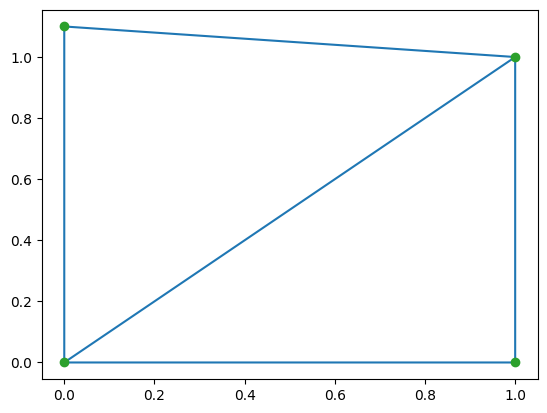

In [21]:
import numpy as np
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])

from scipy.spatial import Delaunay
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [22]:
import numpy as np

# Generate 10 random points with x and y coordinates
num_points = 10
x_coordinates = np.random.rand(num_points)
y_coordinates = np.random.rand(num_points)

# Create an array of points
points = np.column_stack((x_coordinates, y_coordinates))

print("Random Points:")
print(points)


Random Points:
[[0.36047307 0.11842541]
 [0.70268291 0.03969039]
 [0.78981713 0.6928896 ]
 [0.77258727 0.33975921]
 [0.41715403 0.45895331]
 [0.31803432 0.84281654]
 [0.19384044 0.68492791]
 [0.92751304 0.41227935]
 [0.15372515 0.23896191]
 [0.07511069 0.98671101]]


In [23]:
from scipy.spatial import Delaunay
tri = Delaunay(points)

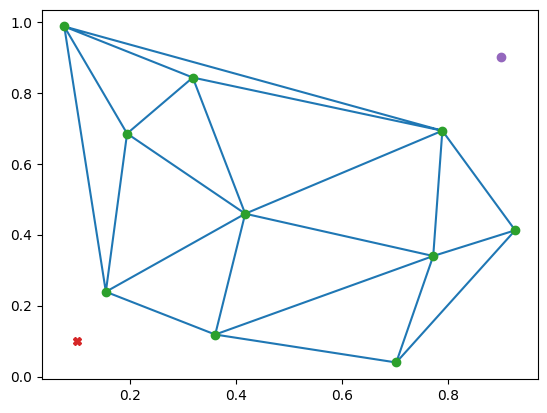

In [26]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(0.1,0.1, "X")
plt.plot(0.9,0.9,"o")
plt.show()

In [32]:
tri.simplices

array([[0, 4, 8],
       [8, 6, 9],
       [4, 6, 8],
       [3, 1, 7],
       [2, 3, 7],
       [3, 2, 4],
       [3, 0, 1],
       [0, 3, 4],
       [2, 5, 4],
       [5, 6, 4],
       [5, 2, 9],
       [6, 5, 9]], dtype=int32)

In [35]:
a1 = points[tri.simplices[0][0]]
print("a1", a1)
a2 = points[tri.simplices[0][1]]
print("a2", a2)
a3 = points[tri.simplices[0][2]]
print("a3", a3)

a1 [0.36047307 0.11842541]
a2 [0.41715403 0.45895331]
a3 [0.15372515 0.23896191]


In [3]:
from shapely.geometry import Polygon, LineString
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from collections import defaultdict

[[10.0, 2.0], [8.27713042139409, 4.0]]


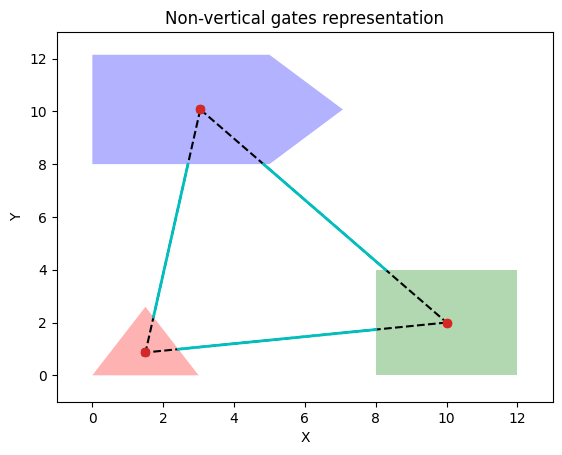

In [4]:
def slope(line: LineString):
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]

    # Calculate the slope
    slope = (y2 - y1) / (x2 - x1)
    
    slope = round(slope,3)
    
    return slope

from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt

# Create a polygon with 3 sides (equilateral triangle)
triangle = Polygon([(0, 0), (3, 0), (1.5, 2.598)])

# Create a polygon with 4 sides (square)
square = Polygon([(8, 0), (12, 0), (12, 4), (8, 4)])

# Create a polygon with 5 sides (regular pentagon)
pentagon = Polygon([(0, 8), (5, 8), (7.071, 10.071), (5, 12.142), (0, 12.142)])


obstacle_list = [triangle, square, pentagon]

centroid1 = list(triangle.centroid.coords)
centroid2 = list(square.centroid.coords)
centroid3 = list(pentagon.centroid.coords)

points = np.array([centroid1, centroid2, centroid3])
points = points.reshape(-1,2)

tri = Delaunay(points)
simplices = tri.simplices

lines = []

for simplex in simplices:
    vertices = points[simplex]
    for i in range(3):
        for j in range(i + 1, 3):
            lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))
            
            
line_intersections = []

for line in lines:
    for obstacle in obstacle_list:
        if obstacle.intersects(LineString(line)):
            line_intersections.append(obstacle.intersection(LineString(line)))
            
            
line_inside_poly = [[list(coord) for coord in line.coords] for line in line_intersections]

print(line_inside_poly[0])


diction_lines = {LineString(long_line_segs) : [] for long_line_segs in lines}
#diction_lines


for long_line_segs in lines:
    for small_line_segs in line_inside_poly:
        if slope(LineString(long_line_segs)) == slope(LineString(small_line_segs)):
            for i in range(2):
                #print(small_line_segs[i])
                diction_lines[LineString(long_line_segs)].append(small_line_segs[i])
                
                
for key, value in diction_lines.items():
    for i in range(2):
        if list(key.coords[i]) in value:
            diction_lines[key].remove(list(key.coords[i]))


gates = []

for values in diction_lines.values():
    gates.append(LineString(values))

# Get the exterior coordinates of each polygon
x1, y1 = triangle.exterior.xy
x2, y2 = square.exterior.xy
x3, y3 = pentagon.exterior.xy

# Create a figure and axis
fig, ax = plt.subplots()

# Fill the polygons
ax.fill(x1, y1, 'r', alpha=0.3, label='Triangle')
ax.fill(x2, y2, 'g', alpha=0.3, label='Square')
ax.fill(x3, y3, 'b', alpha=0.3, label='Pentagon')

plt.plot(centroid1[0][0], centroid1[0][1], 'X')
plt.plot(centroid2[0][0], centroid2[0][1], 'X')
plt.plot(centroid3[0][0], centroid3[0][1], 'X')

plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'k--')
plt.plot(points[:,0], points[:,1], 'o')

for gate in gates:
    x, y = gate.xy
    plt.plot(x, y, 'c-', linewidth=2)

# Set axis limits
ax.set_xlim(-1, 13)
ax.set_ylim(-1, 13)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Non-vertical gates representation')

# Add legend
#ax.legend()
#plt.legend()
# Show the plot
plt.show()


In [5]:
lines

[<LINESTRING (10 2, 3.047 10.071)>,
 <LINESTRING (10 2, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 1.5 0.866)>]

In [50]:
def slope(line: LineString):
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]

    # Calculate the slope
    slope = (y2 - y1) / (x2 - x1)
    
    slope = round(slope,3)
    
    return slope


from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
from collections import defaultdict


# Create a polygon with 3 sides (equilateral triangle)
triangle = Polygon([(0, 0), (3, 0), (1.5, 2.598)])

# Create a polygon with 4 sides (square)
square = Polygon([(8, 0), (12, 0), (12, 4), (8, 4)])

# Create a polygon with 5 sides (regular pentagon)
pentagon = Polygon([(0, 8), (5, 8), (7.071, 10.071), (5, 12.142), (0, 12.142)])

triangle_new = Polygon([(8,8),(12, 12), (12, 8)])

obstacle_list = [triangle, square, pentagon, triangle_new]

centroid1 = list(triangle.centroid.coords)
centroid2 = list(square.centroid.coords)
centroid3 = list(pentagon.centroid.coords)
centroid4 = list(triangle_new.centroid.coords)

points = np.array([centroid1, centroid2, centroid3, centroid4])
points = points.reshape(-1,2)

tri = Delaunay(points)
simplices = tri.simplices

lines = []

for simplex in simplices:
    vertices = points[simplex]
    for i in range(3):
        for j in range(i + 1, 3):
            lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))


line_dict = defaultdict(list)

for line in lines:
    slope = calculate_slope(line)
    line_dict[slope].append(line)
    

filtered_lines = []
for slope, line_list in line_dict.items():
    filtered_lines.append(line_list[0])

#print(filtered_lines)

################################################################3


line_intersections = []

for line in filtered_lines:
    for obstacle in obstacle_list:
        if obstacle.intersects(line):
            #print(f"Obstacle {j+1} intersects line {i+1}")
            line_intersections.append(obstacle.intersection(line))
#print(line_intersections)

           
            
line_inside_poly = [[list(coord) for coord in line.coords] for line in line_intersections]

print(line_inside_poly[0])



for long_line_segs in lines:
    for small_line_segs in line_inside_poly:
        if slope(LineString(long_line_segs)) == slope(LineString(small_line_segs)):
            for i in range(2):
                #print(small_line_segs[i])
                diction_lines[LineString(long_line_segs)].append(small_line_segs[i])
   

    for long_line_segs in filtered_lines:
    for small_line_segs in line_inside_poly:
        if calculate_slope(long_line_segs) == calculate_slope(small_line_segs):
            for i in range(2):
                print(small_line_segs[i])
                diction_lines[LineString(long_line_segs)].append(small_line_segs[i])
                
                
for key, value in diction_lines.items():
    for i in range(2):
        if list(key.coords[i]) in value:
            diction_lines[key].remove(list(key.coords[i]))


gates = []

for values in diction_lines.values():
    gates.append(LineString(values))

# Get the exterior coordinates of each polygon
x1, y1 = triangle.exterior.xy
x2, y2 = square.exterior.xy
x3, y3 = pentagon.exterior.xy
x4, y4 = triangle_new.exterior.xy

# Create a figure and axis
fig, ax = plt.subplots()

# Fill the polygons
ax.fill(x1, y1, 'r', alpha=0.3, label='Triangle')
ax.fill(x2, y2, 'g', alpha=0.3, label='Square')
ax.fill(x3, y3, 'b', alpha=0.3, label='Pentagon')
ax.fill(x4, y4, 'cyan', alpha=0.3, label='Triangle_New')

plt.plot(centroid1[0][0], centroid1[0][1], 'X')
plt.plot(centroid2[0][0], centroid2[0][1], 'X')
plt.plot(centroid3[0][0], centroid3[0][1], 'X')

plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'k--')
plt.plot(points[:,0], points[:,1], 'o')

for gate in gates:
    x, y = gate.xy
    plt.plot(x, y, 'c-', linewidth=2)

# Set axis limits
ax.set_xlim(-1, 13)
ax.set_ylim(-1, 13)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Non-vertical gates representation')

# Add legend
#ax.legend()
#plt.legend()
# Show the plot
plt.show()


IndentationError: expected an indented block (3483946928.py, line 93)

In [528]:
def calculate_slope(line):
    p1, p2 = line.coords
    if p2[0] - p1[0] != 0:
        a =  (p2[1] - p1[1]) / (p2[0] - p1[0])
        return round(a,3)
    else:
        return float('inf')

In [526]:
line = LineString([(1,2),(5,7)])
p1, p2 = line.coords
p1

(1.0, 2.0)

In [449]:
points

array([[ 1.5       ,  0.866     ],
       [10.        ,  2.        ],
       [ 3.04735982, 10.071     ],
       [10.66666667,  9.33333333]])

In [448]:
for simplex in simplices:
    print(simplex)

[1 2 0]
[2 1 3]


In [489]:


lines = []

for simplex in simplices:
    vertices = points[simplex]
    for i in range(3):
        for j in range(i + 1, 3):
            lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))
            

In [490]:
from collections import defaultdict
line_dict = defaultdict(list)
for line in lines:
    slope = calculate_slope(line)
    line_dict[slope].append(line)
    
filtered_lines = []
for slope, line_list in line_dict.items():
    filtered_lines.append(line_list[0])

print(filtered_lines)

[<LINESTRING (10 2, 3.047 10.071)>, <LINESTRING (10 2, 1.5 0.866)>, <LINESTRING (3.047 10.071, 1.5 0.866)>, <LINESTRING (3.047 10.071, 10.667 9.333)>, <LINESTRING (10 2, 10.667 9.333)>]


In [491]:
filtered_lines

[<LINESTRING (10 2, 3.047 10.071)>,
 <LINESTRING (10 2, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 10.667 9.333)>,
 <LINESTRING (10 2, 10.667 9.333)>]

defaultdict(list, {})

In [451]:
obstacle_list[2].intersects(lines[0])

True

In [506]:
line_intersections = []

for i, line in enumerate(filtered_lines):
    for j, obstacle in enumerate(obstacle_list):
        if obstacle.intersects(line):
            print(f"Obstacle {j+1} intersects line {i+1}")
            line_intersections.append(obstacle.intersection(line))

#line_intersections.append(obstacle.intersection(line))
#else:
#  print(f"Obstacle {j+1} does not intersects line {i+1}")

line_intersections

Obstacle 2 intersects line 1
Obstacle 3 intersects line 1
Obstacle 1 intersects line 2
Obstacle 2 intersects line 2
Obstacle 1 intersects line 3
Obstacle 3 intersects line 3
Obstacle 3 intersects line 4
Obstacle 4 intersects line 4
Obstacle 2 intersects line 5
Obstacle 4 intersects line 5


[<LINESTRING (10 2, 8.277 4)>,
 <LINESTRING (4.831 8, 3.047 10.071)>,
 <LINESTRING (2.428 0.99, 1.5 0.866)>,
 <LINESTRING (10 2, 8 1.733)>,
 <LINESTRING (1.725 2.207, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 2.699 8)>,
 <LINESTRING (3.047 10.071, 6.716 9.716)>,
 <LINESTRING (9.451 9.451, 10.667 9.333)>,
 <LINESTRING (10 2, 10.182 4)>,
 <LINESTRING (10.545 8, 10.667 9.333)>]

In [514]:
line_inside_poly = [[list(coord) for coord in line.coords] for line in line_intersections]
line_inside_poly

[[[10.0, 2.0], [8.27713042139409, 4.0]],
 [[4.831391264182274, 8.0], [3.0473598155358577, 10.070999999999998]],
 [[2.428481331987891, 0.9898703329969727],
  [1.5000000000000002, 0.8659999999999999]],
 [[10.0, 2.0], [8.0, 1.7331764705882353]],
 [[1.7254960931341858, 2.20744076669159],
  [1.5000000000000002, 0.8659999999999999]],
 [[3.0473598155358577, 10.070999999999998], [2.6992248695309953, 8.0]],
 [[3.0473598155358577, 10.070999999999998],
  [6.715834911057373, 9.715834911057373]],
 [[9.451026126479192, 9.451026126479192],
  [10.666666666666666, 9.333333333333334]],
 [[10.0, 2.0], [10.181818181818182, 4.0]],
 [[10.545454545454545, 8.0], [10.666666666666666, 9.333333333333334]]]

In [511]:
#print(line_inside_poly)
diction_lines = {LineString(long_line_segs) : [] for long_line_segs in filtered_lines}
diction_lines

{<LINESTRING (10 2, 3.047 10.071)>: [],
 <LINESTRING (10 2, 1.5 0.866)>: [],
 <LINESTRING (3.047 10.071, 1.5 0.866)>: [],
 <LINESTRING (3.047 10.071, 10.667 9.333)>: [],
 <LINESTRING (10 2, 10.667 9.333)>: []}

In [509]:
for a in filtered_lines:
    print(calculate_slope(a))

-1.161
0.133
5.949
-0.097
11.0


In [510]:
for b in line_intersections:
    print(calculate_slope(b))

-1.161
-1.161
0.133
0.133
5.949
5.949
-0.097
-0.097
11.0
11.0


In [513]:
for long_line_segs in filtered_lines:
    for small_line_segs in line_intersections:
        if calculate_slope(long_line_segs) == calculate_slope(small_line_segs):
            diction_lines[long_line_segs] = small_line_segs
            #for i in range(2):
                #print(small_line_segs[i])
                #diction_lines[LineString(long_line_segs)].append(small_line_segs[i])

In [501]:
diction_lines

{<LINESTRING (10 2, 3.047 10.071)>: [[4.831391264182274, 8.0],
  [3.0473598155358577, 10.070999999999998],
  [4.831391264182274, 8.0],
  [3.0473598155358577, 10.070999999999998]],
 <LINESTRING (10 2, 1.5 0.866)>: [],
 <LINESTRING (3.047 10.071, 1.5 0.866)>: [[3.0473598155358577,
   10.070999999999998],
  [2.6992248695309953, 8.0],
  [3.0473598155358577, 10.070999999999998],
  [2.6992248695309953, 8.0]],
 <LINESTRING (3.047 10.071, 10.667 9.333)>: [],
 <LINESTRING (10 2, 10.667 9.333)>: [[10.0, 2.0],
  [10.181818181818182, 4.0],
  [10.0, 2.0],
  [10.181818181818182, 4.0]]}

In [488]:
line_intersections

[<LINESTRING (10 2, 8.277 4)>,
 <LINESTRING (4.831 8, 3.047 10.071)>,
 <LINESTRING (2.428 0.99, 1.5 0.866)>,
 <LINESTRING (10 2, 8 1.733)>,
 <LINESTRING (1.725 2.207, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 2.699 8)>,
 <LINESTRING (3.047 10.071, 6.716 9.716)>,
 <LINESTRING (9.451 9.451, 10.667 9.333)>,
 <LINESTRING (10 2, 10.182 4)>,
 <LINESTRING (10.545 8, 10.667 9.333)>]

In [429]:
lines = []

for simplex in simplices:
    vertices = points[simplex]
    for i in range(3):
        for j in range(i + 1, 3):
            lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))


    

In [430]:
lines = [<LINESTRING (10 2, 3.047 10.071)>,
 <LINESTRING (10 2, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 10 2)>,
 <LINESTRING (3.047 10.071, 10.667 9.333)>,
 <LINESTRING (10 2, 10.667 9.333)>]

[<LINESTRING (10 2, 3.047 10.071)>,
 <LINESTRING (10 2, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 1.5 0.866)>,
 <LINESTRING (3.047 10.071, 10 2)>,
 <LINESTRING (3.047 10.071, 10.667 9.333)>,
 <LINESTRING (10 2, 10.667 9.333)>]

In [432]:
lines = []

for simplex in simplices:
    vertices = points[simplex]
    for i in range(3):
        for j in range(i + 1, 3):
            lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))



In [436]:
indices = []
for i in range(len(lines)-1):
    for j in range(1, len(lines)):
        if slope(lines[i]) == slope(lines[j]):
            indices.append(i)
            
indices

[0, 1, 2, 3, 4]

In [428]:
for simplex in tri.simplices:
    print(simplex)

[1 2 0]
[2 1 3]


In [415]:
gates

[<LINESTRING (8.277 4, 4.831 8)>,
 <LINESTRING (2.428 0.99, 8 1.733)>,
 <LINESTRING (1.725 2.207, 2.699 8)>]

In [333]:
centroid1

[(1.5000000000000002, 0.8659999999999999)]

In [303]:
lines

[[(10.0, 2.0), (3.0473598155358577, 10.070999999999998)],
 [(10.0, 2.0), (1.5000000000000002, 0.8659999999999999)],
 [(3.0473598155358577, 10.070999999999998),
  (1.5000000000000002, 0.8659999999999999)]]

In [300]:
lines = []

for simplex in simplices:
    vertices = points[simplex]
    for i in range(3):
        for j in range(i + 1, 3):
            lines.append(LineString([tuple(vertices[i]), tuple(vertices[j])]))

In [413]:
lines[0]

[(10.0, 2.0), (3.0473598155358577, 10.070999999999998)]

In [305]:
print(lines[0])

[(10.0, 2.0), (3.0473598155358577, 10.070999999999998)]


In [306]:
obstacle_list

[<POLYGON ((0 0, 3 0, 1.5 2.598, 0 0))>,
 <POLYGON ((8 0, 12 0, 12 4, 8 4, 8 0))>,
 <POLYGON ((0 8, 5 8, 7.071 10.071, 5 12.142, 0 12.142, 0 8))>]

In [268]:
line_intersections = []

for line in lines:
    for obstacle in obstacle_list:
        if obstacle.intersects(LineString(line)):
            line_intersections.append(obstacle.intersection(LineString(line)))

In [366]:
line_inside_poly = [[list(coord) for coord in line.coords] for line in line_intersections]

print(line_inside_poly)

[[[10.0, 2.0], [8.27713042139409, 4.0]], [[4.831391264182274, 8.0], [3.0473598155358577, 10.070999999999998]], [[2.428481331987891, 0.9898703329969727], [1.5000000000000002, 0.8659999999999999]], [[10.0, 2.0], [8.0, 1.7331764705882353]], [[1.7254960931341858, 2.20744076669159], [1.5000000000000002, 0.8659999999999999]], [[3.0473598155358577, 10.070999999999998], [2.6992248695309953, 8.0]]]


In [367]:
line_inside_poly

[[[10.0, 2.0], [8.27713042139409, 4.0]],
 [[4.831391264182274, 8.0], [3.0473598155358577, 10.070999999999998]],
 [[2.428481331987891, 0.9898703329969727],
  [1.5000000000000002, 0.8659999999999999]],
 [[10.0, 2.0], [8.0, 1.7331764705882353]],
 [[1.7254960931341858, 2.20744076669159],
  [1.5000000000000002, 0.8659999999999999]],
 [[3.0473598155358577, 10.070999999999998], [2.6992248695309953, 8.0]]]

In [395]:
diction_lines = {LineString(long_line_segs) : [] for long_line_segs in lines}
diction_lines
        

{<LINESTRING (10 2, 3.047 10.071)>: [],
 <LINESTRING (10 2, 1.5 0.866)>: [],
 <LINESTRING (3.047 10.071, 1.5 0.866)>: []}

In [396]:
for long_line_segs in lines:
    for small_line_segs in line_inside_poly:
        if slope(LineString(long_line_segs)) == slope(LineString(small_line_segs)):
            for i in range(2):
                print(small_line_segs[i])
                diction_lines[LineString(long_line_segs)].append(small_line_segs[i])

[10.0, 2.0]
[8.27713042139409, 4.0]
[4.831391264182274, 8.0]
[3.0473598155358577, 10.070999999999998]
[2.428481331987891, 0.9898703329969727]
[1.5000000000000002, 0.8659999999999999]
[10.0, 2.0]
[8.0, 1.7331764705882353]
[1.7254960931341858, 2.20744076669159]
[1.5000000000000002, 0.8659999999999999]
[3.0473598155358577, 10.070999999999998]
[2.6992248695309953, 8.0]


In [407]:
for key, value in diction_lines.items():
    for i in range(2):
        if list(key.coords[i]) in value:
            diction_lines[key].remove(list(key.coords[i]))

In [408]:
diction_lines

{<LINESTRING (10 2, 3.047 10.071)>: [[8.27713042139409, 4.0],
  [4.831391264182274, 8.0]],
 <LINESTRING (10 2, 1.5 0.866)>: [[2.428481331987891, 0.9898703329969727],
  [8.0, 1.7331764705882353]],
 <LINESTRING (3.047 10.071, 1.5 0.866)>: [[1.7254960931341858,
   2.20744076669159],
  [2.6992248695309953, 8.0]]}

In [409]:
gates = []

for values in diction_lines.values():
    gates.append(LineString(values))

In [410]:
gates

[<LINESTRING (8.277 4, 4.831 8)>,
 <LINESTRING (2.428 0.99, 8 1.733)>,
 <LINESTRING (1.725 2.207, 2.699 8)>]

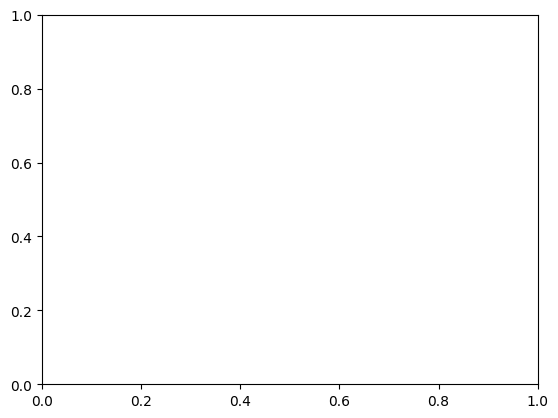

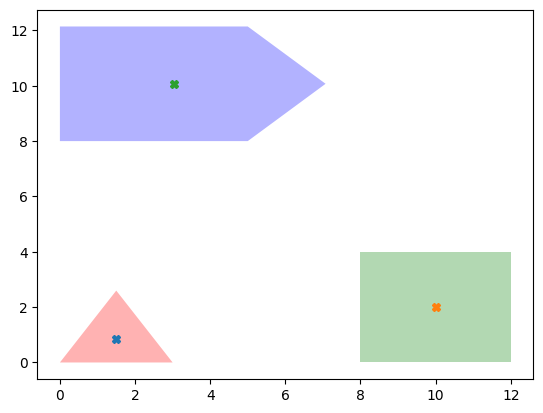

In [412]:
fig, ax = plt.subplots()

# Get the exterior coordinates of each polygon
x1, y1 = triangle.exterior.xy
x2, y2 = square.exterior.xy
x3, y3 = pentagon.exterior.xy

# Create a figure and axis
fig, ax = plt.subplots()

# Fill the polygons
ax.fill(x1, y1, 'r', alpha=0.3, label='Triangle')
ax.fill(x2, y2, 'g', alpha=0.3, label='Square')
ax.fill(x3, y3, 'b', alpha=0.3, label='Pentagon')

plt.plot(centroid1[0][0], centroid1[0][1], 'X')
plt.plot(centroid2[0][0], centroid2[0][1], 'X')
plt.plot(centroid3[0][0], centroid3[0][1], 'X')

In [398]:
list(LineString(lines[0]).coords[0])

[10.0, 2.0]

In [406]:
a =[1,2,3]
a.remove(2)
a

[1, 3]

In [400]:
diction_lines[LineString(lines[0])][0]

[10.0, 2.0]

In [379]:
new_diction = {LineString(long_line_segs) : [] for long_line_segs in lines}

for key, values in diction_lines.items():
    for i in range(2):
        for j in range(2):
            new_diction[key].append(value[i][j])

In [380]:
new_diction

{<LINESTRING (10 2, 3.047 10.071)>: [[1.7254960931341858, 2.20744076669159],
  [1.5000000000000002, 0.8659999999999999],
  [3.0473598155358577, 10.070999999999998],
  [2.6992248695309953, 8.0]],
 <LINESTRING (10 2, 1.5 0.866)>: [[1.7254960931341858, 2.20744076669159],
  [1.5000000000000002, 0.8659999999999999],
  [3.0473598155358577, 10.070999999999998],
  [2.6992248695309953, 8.0]],
 <LINESTRING (3.047 10.071, 1.5 0.866)>: [[1.7254960931341858,
   2.20744076669159],
  [1.5000000000000002, 0.8659999999999999],
  [3.0473598155358577, 10.070999999999998],
  [2.6992248695309953, 8.0]]}

In [336]:
centroid1

[(1.5000000000000002, 0.8659999999999999)]

In [371]:
diction_lines[LineString(lines[0])] = [[[10.0, 2.0], [8.27713042139409, 4.0]],
 [[4.831391264182274, 8.0], [3.0473598155358577, 10.070999999999998]]]

[[[10.0, 2.0], [8.27713042139409, 4.0]],
 [[4.831391264182274, 8.0], [3.0473598155358577, 10.070999999999998]]]

In [313]:
for _ in lines:
    print(_)

[(10.0, 2.0), (3.0473598155358577, 10.070999999999998)]
[(10.0, 2.0), (1.5000000000000002, 0.8659999999999999)]
[(3.0473598155358577, 10.070999999999998), (1.5000000000000002, 0.8659999999999999)]


In [372]:
for key, value in diction_lines.items():
    for i in range(0,2):
        print(tuple(key.coords[i]))
        for j in range(0,2):
            #print(value[j])
            for k in range(0,2):
                print(value[j][k])
    
    #print(list(key.coords[0]))
    #print(list(key.coords[1]))
    #print(list(value[0][0]))
      
    print("#########")

(10.0, 2.0)
[10.0, 2.0]
[8.27713042139409, 4.0]
[4.831391264182274, 8.0]
[3.0473598155358577, 10.070999999999998]
(3.0473598155358577, 10.070999999999998)
[10.0, 2.0]
[8.27713042139409, 4.0]
[4.831391264182274, 8.0]
[3.0473598155358577, 10.070999999999998]
#########
(10.0, 2.0)
[2.428481331987891, 0.9898703329969727]
[1.5000000000000002, 0.8659999999999999]
[10.0, 2.0]
[8.0, 1.7331764705882353]
(1.5000000000000002, 0.8659999999999999)
[2.428481331987891, 0.9898703329969727]
[1.5000000000000002, 0.8659999999999999]
[10.0, 2.0]
[8.0, 1.7331764705882353]
#########
(3.0473598155358577, 10.070999999999998)
[1.7254960931341858, 2.20744076669159]
[1.5000000000000002, 0.8659999999999999]
[3.0473598155358577, 10.070999999999998]
[2.6992248695309953, 8.0]
(1.5000000000000002, 0.8659999999999999)
[1.7254960931341858, 2.20744076669159]
[1.5000000000000002, 0.8659999999999999]
[3.0473598155358577, 10.070999999999998]
[2.6992248695309953, 8.0]
#########


In [349]:
centroid1, centroid2

([(1.5000000000000002, 0.8659999999999999)], [(10.0, 2.0)])

In [290]:
hello = []

for long_linesegs in lines:
    for small_linesegs in line_inside_poly:
        if slope(LineString(long_linesegs)) == slope(LineString(small_linesegs)):
            x = discard_common_vertex(small_linesegs, long_linesegs)
            hello.append(x)

hello

[[(8.27713042139409, 4.0), (3.0473598155358577, 10.070999999999998)],
 [(4.831391264182274, 8.0), (10.0, 2.0)],
 [(2.428481331987891, 0.9898703329969727), (10.0, 2.0)],
 [(8.0, 1.7331764705882353), (1.5000000000000002, 0.8659999999999999)],
 [(1.7254960931341858, 2.20744076669159),
  (3.0473598155358577, 10.070999999999998)],
 [(2.6992248695309953, 8.0), (1.5000000000000002, 0.8659999999999999)]]

In [289]:
for _ in hello:
    print(slope(LineString(_)))

-1.161
-1.161
0.133
0.133
5.949
5.949


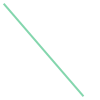

In [185]:
line_intersections[1]

In [172]:
print(line_intersections[1])

LINESTRING (10 2, 8.27713042139409 4)


In [173]:
print(lines[0].difference(line_intersections[1]))

LINESTRING (10 2, 3.0473598155358577 10.070999999999998)


In [186]:
x1, y1 = lines[0].xy

In [187]:
x1

array('d', [10.0, 3.0473598155358577])

In [188]:
y1

array('d', [2.0, 10.070999999999998])

In [189]:
x2, y2 = line_intersections[1].xy

In [190]:
x2

array('d', [10.0, 8.27713042139409])

In [191]:
y2

array('d', [2.0, 4.0])

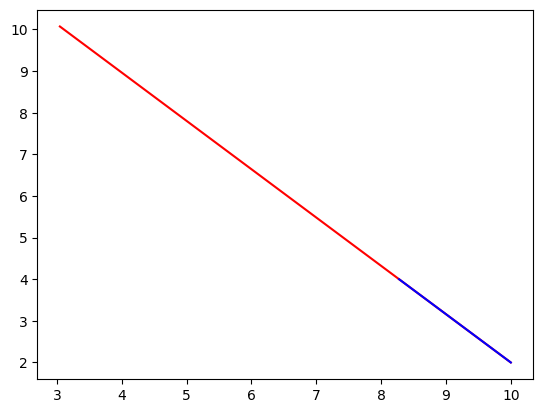

In [192]:
fig, ax = plt.subplots()

plt.plot(x1,y1, 'red')
plt.plot(x2,y2, 'blue')

In [235]:
line1 = lines[0]

slope1 = slope(line1)
print(slope1)

-1.161


In [236]:
line2 = line_intersections[1]

slope2 = slope(line2)
print(slope2)

-1.161


In [242]:
print(line1)
print(line2)

LINESTRING (10 2, 3.0473598155358577 10.070999999999998)
LINESTRING (10 2, 8.27713042139409 4)


In [ ]:
if slope(line1) == slope(line2):
    new_line = Line

tuple

In [199]:
line1.intersects(line2)

True

In [202]:
print(line2.difference(line1))

LINESTRING (10 2, 8.27713042139409 4)


In [259]:
new_line = []

for line in lines:
    for line_seg in line_intersections:
        new_line.append(slope(line) == slope(line_seg))
            

In [260]:
new_line

[True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True]

In [155]:
lines[0].(line_intersections[1])

False

In [156]:
line_intersections[1].covered_by(lines[0])

False

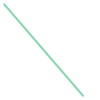

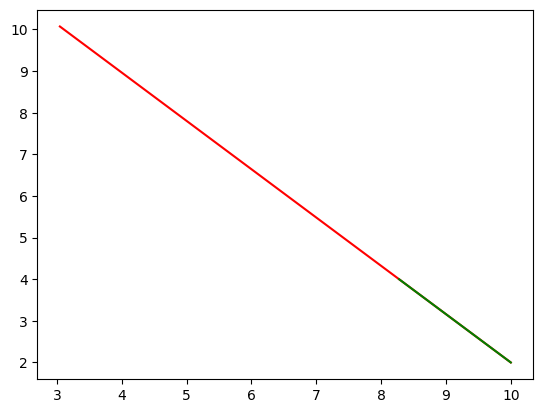

In [218]:
from shapely.geometry import LineString

# Create two LineString objects
line1 = LineString([(10, 2), (3.047, 10.0709)])
line2 = LineString([(10, 2), (8.277, 4)])

x1,y1 = line1.xy
x2,y2 = line2.xy

fix, ax = plt.subplots()

plt.plot(x1,y1, 'red')
plt.plot(x2,y2, 'green')

line1.difference(line2)
# Find the difference of the two LineString objects
#difference = line1.difference(line2)

# Print the resulting geometry (could be empty if there's no difference)
#print(difference)


In [219]:
x1

array('d', [10.0, 3.047])

In [220]:
y1

array('d', [2.0, 10.0709])

In [221]:
x2

array('d', [10.0, 8.277])

In [222]:
y2

array('d', [2.0, 4.0])

In [223]:
dif = line1.difference(line2)

In [224]:
print(dif)

LINESTRING (10 2, 3.047 10.0709)


In [225]:
x, y = dif.xy

In [226]:
x

array('d', [10.0, 3.047])

In [217]:
y

array('d', [0.0, 1.0])

In [227]:
from shapely.geometry import LineString

# Create a LineString object
line = LineString([(1, 2), (4, 5)])

# Extract coordinates from LineString endpoints
x1, y1 = line.coords[0]
x2, y2 = line.coords[1]

# Calculate the slope
slope = (y2 - y1) / (x2 - x1)

print("Slope of the line:", slope)


Slope of the line: 1.0


In [516]:
def slope(line: LineString):
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[1]

    # Calculate the slope
    slope = (y2 - y1) / (x2 - x1)
    
    slope = round(slope,3)
    
    return slope

In [261]:
slope(line1)

-1.161

In [283]:
long_linesegs = lines[0]
long_linesegs = [(10.0, 2.0), (3.0473598155358577, 10.070999999999998)]

[(10.0, 2.0), (3.0473598155358577, 10.070999999999998)]

In [284]:
small_linesegs = line_inside_poly[0]
small_linesegs = [(10.0, 2.0), (8.27713042139409, 4.0)]

[(10.0, 2.0), (8.27713042139409, 4.0)]

In [285]:
long_linesegs = [(10.0, 2.0), (3.0473598155358577, 10.070999999999998)]
small_linesegs = [(10.0, 2.0), (8.27713042139409, 4.0)]

In [286]:
def discard_common_vertex(line1, line2):
    common_vertex = None
    for vertex in line1:
        if vertex in line2:
            common_vertex = vertex
            break
    
    if common_vertex is None:
        return None
    
    new_line = [vertex for vertex in line1 if vertex != common_vertex] + [vertex for vertex in line2 if vertex != common_vertex]
    return new_line

# Test with your example data
long_linesegs = [(10.0, 2.0), (3.0473598155358577, 10.070999999999998)]
small_linesegs = [(10.0, 2.0), (8.27713042139409, 4.0)]

new_line = discard_common_vertex(long_linesegs, small_linesegs)
print(new_line)


[(3.0473598155358577, 10.070999999999998), (8.27713042139409, 4.0)]


In [291]:
from shapely.geometry import LineString

def subtract_lines(original_lines, small_line_segments):
    subtracted_lines = []

    for segment in small_line_segments:
        segment_line = LineString(segment)
        segment_slope = slope(segment_line)

        for line in original_lines:
            line_string = LineString(line)
            line_slope = slope(line_string)

            if line_slope == segment_slope:
                # Subtract the coordinates of the segment from the line
                subtracted_coords = [(x1 - x2, y1 - y2) for ((x1, y1), (x2, y2)) in zip(line, segment)]
                subtracted_lines.append(subtracted_coords)
                break  # Move to the next segment

    return subtracted_lines

# Your original lines and small line segments
lines = [[(10.0, 2.0), (3.0473598155358577, 10.070999999999998)],
         [(10.0, 2.0), (1.5000000000000002, 0.8659999999999999)],
         [(3.0473598155358577, 10.070999999999998), (1.5000000000000002, 0.8659999999999999)]]

small_line_segments = [[(10.0, 2.0), (8.27713042139409, 4.0)],
                      [(4.831391264182274, 8.0), (3.0473598155358577, 10.070999999999998)],
                      [(2.428481331987891, 0.9898703329969727), (1.5000000000000002, 0.8659999999999999)],
                      [(10.0, 2.0), (8.0, 1.7331764705882353)],
                      [(1.7254960931341858, 2.20744076669159), (1.5000000000000002, 0.8659999999999999)],
                      [(3.0473598155358577, 10.070999999999998), (2.6992248695309953, 8.0)]]

result = subtract_lines(lines, small_line_segments)
print(result)


[[(0.0, 0.0), (-5.229770605858233, 6.070999999999998)], [(5.168608735817726, -6.0), (0.0, 0.0)], [(7.571518668012109, 1.0101296670030273), (0.0, 0.0)], [(0.0, 0.0), (-6.5, -0.8671764705882354)], [(1.3218637224016718, 7.863559233308408), (0.0, 0.0)], [(0.0, 0.0), (-1.199224869530995, -7.134)]]


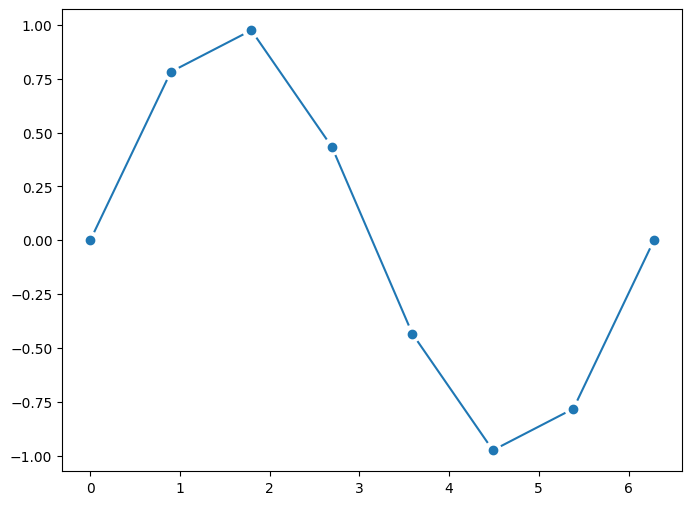

In [296]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class MyTransform(mpl.transforms.Transform):
  input_dims = 2
  output_dims = 2
  def __init__(self, base_point, base_transform, offset, *kargs, **kwargs):
    self.base_point = base_point
    self.base_transform = base_transform
    self.offset = offset
    super(mpl.transforms.Transform, self).__init__(*kargs, **kwargs)
  def transform_non_affine(self, values):
    new_base_point = self.base_transform.transform(self.base_point)
    t = mpl.transforms.Affine2D().translate(-new_base_point[0], -new_base_point[1])
    values = t.transform(values)
    x = values[:, 0:1]
    y = values[:, 1:2]
    r = np.sqrt(x**2+y**2)
    new_r = r-self.offset
    new_r[new_r<0] = 0.0
    new_x = new_r/r*x
    new_y = new_r/r*y
    return t.inverted().transform(np.concatenate((new_x, new_y), axis=1))

def my_plot(X,Y):
  ax = plt.gca()
  line, = ax.plot(X, Y, marker='o', linestyle='')
  color = line.get_color()

  size = X.size
  for i in range(1,size):
    mid_x = (X[i]+X[i-1])/2
    mid_y = (Y[i]+Y[i-1])/2

    # this transform takes data coords and returns display coords
    t = ax.transData

    # this transform takes display coords and 
    # returns them shifted by `offset' towards `base_point'
    my_t = MyTransform(base_point=(mid_x, mid_y), base_transform=t, offset=10)

    # resulting combination of transforms
    t_end = t + my_t

    line, = ax.plot(
      [X[i-1], X[i]],
      [Y[i-1], Y[i]],
      linestyle='-', color=color)
    line.set_transform(t_end)

fig = plt.figure(figsize=(8,6))
axes = plt.subplot(111)

X = np.linspace(0,2*np.pi, 8)
Y = np.sin(X)
my_plot(X,Y)
plt.show()

In [295]:
pip install zoneinfo

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement zoneinfo (from versions: none)
ERROR: No matching distribution found for zoneinfo
Note: you may need to restart the kernel to use updated packages.


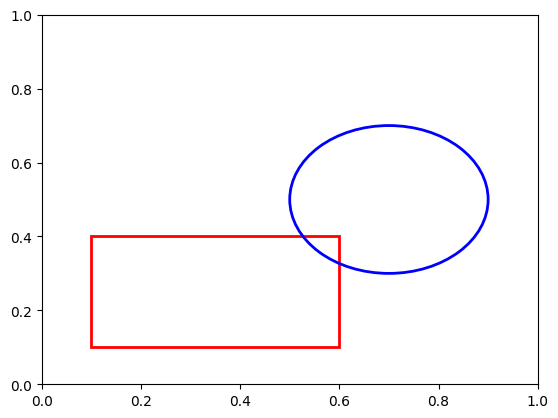

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Create a rectangle
rectangle = patches.Rectangle((0.1, 0.1), 0.5, 0.3, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rectangle)

# Create a circle
circle = patches.Circle((0.7, 0.5), 0.2, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(circle)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()


In [11]:
rectangle.get_corners()

array([[0.1, 0.1],
       [0.6, 0.1],
       [0.6, 0.4],
       [0.1, 0.4]])

KeyboardInterrupt: 

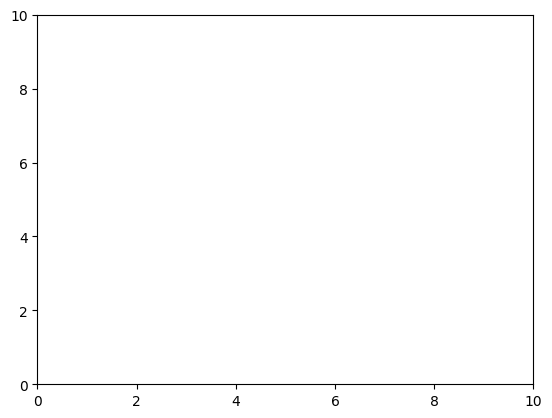

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from shapely.geometry import Polygon

def is_convex(polygon):
    return polygon.convex_hull == polygon

def aspect_ratio(polygon):
    min_x, min_y, max_x, max_y = polygon.bounds
    width = max_x - min_x
    height = max_y - min_y
    return max(width / height, height / width)

# Set the number of shapes
num_shapes = 10

# Create a figure and axis
fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Create random polygons
polygons = []
while len(polygons) < num_shapes:
    num_sides = np.random.randint(3, 7)  # Random number of sides between 3 and 6
    x = np.random.uniform(0, 10, num_sides)
    y = np.random.uniform(0, 10, num_sides)

    # Close the polygon by repeating the first point
    x = np.append(x, x[0])
    y = np.append(y, y[0])

    # Create the polygon using Shapely
    polygon = Polygon(np.column_stack((x, y)))

    # Check for convexity, aspect ratio, and intersections with existing polygons
    if is_convex(polygon) and 0.4 <= aspect_ratio(polygon) <= 1.0:
        intersect = False
        for p in polygons:
            if polygon.intersects(p):
                intersect = True
                break
        
        if not intersect:
            polygons.append(polygon)
            # Add the polygon patch to the axis
            polygon_patch = patches.Polygon(np.column_stack((x, y)), closed=True, edgecolor='black', linewidth=1)
            ax.add_patch(polygon_patch)

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Random Non-Intersecting Convex Shapes with Moderate Aspect Ratio')

# Show the plot
plt.show()


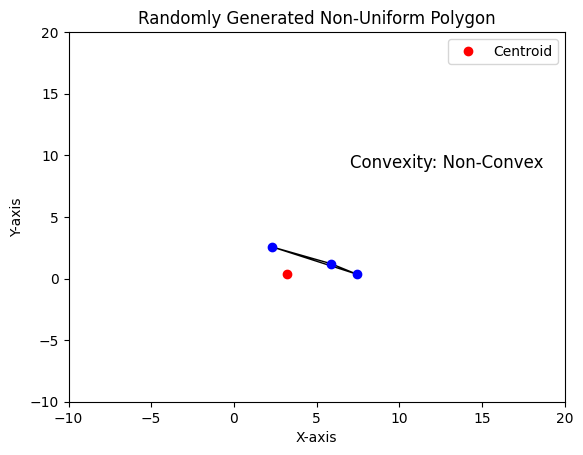

In [49]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generate_non_uniform_polygon(centroid, radii, angles):
    vertices = []
    for radius, angle in zip(radii, angles):
        x = centroid[0] + radius * math.cos(angle)
        y = centroid[1] + radius * math.sin(angle)
        vertices.append((x, y))
    return vertices

def is_convex_polygon(vertices):
    num_vertices = len(vertices)
    if num_vertices < 3:
        return False
    
    for i in range(num_vertices):
        p1 = vertices[i]
        p2 = vertices[(i + 1) % num_vertices]
        p3 = vertices[(i + 2) % num_vertices]
        
        cross_product = (p2[0] - p1[0]) * (p3[1] - p2[1]) - (p2[1] - p1[1]) * (p3[0] - p2[0])
        if cross_product <= 0:
            return False
    
    return True

# Generate random centroid
centroid = (random.uniform(0, 10), random.uniform(0, 10))

# Number of vertices for the polygon
num_vertices = random.randint(3, 3)

# Generate random radii and angles
radii = [random.uniform(1, 5) for _ in range(num_vertices)]
angles = [random.uniform(0, 2*math.pi) for _ in range(num_vertices)]

# Generate non-uniform polygon vertices
polygon_vertices = generate_non_uniform_polygon(centroid, radii, angles)

# Check if the polygon is convex
is_convex = is_convex_polygon(polygon_vertices)

# Create the plot
fig, ax = plt.subplots()

# Plot the centroid
ax.plot(centroid[0], centroid[1], 'ro', label='Centroid')

# Plot the vertices
for vertex in polygon_vertices:
    ax.plot(vertex[0], vertex[1], 'bo')

# Plot the polygon
polygon_patch = patches.Polygon(polygon_vertices, closed=True, fill=False)
ax.add_patch(polygon_patch)

# Set plot limits
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)

# Add labels and legend
ax.set_title('Randomly Generated Non-Uniform Polygon')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()

# Display the convexity information
convexity_label = 'Convex' if is_convex else 'Non-Convex'
ax.text(7, 9, f'Convexity: {convexity_label}', fontsize=12, color='black')

# Display the plot
plt.show()


In [33]:
centroid

(6.22450485178836, 5.2862341705013485)

In [35]:
polygon_vertices = Polygon(polygon_vertices)

In [36]:
polygon_vertices.centroid.coords.xy

(array('d', [5.594560778588819]), array('d', [5.603102760347168]))

In [51]:
import math

def calculate_angle_increments(num_sides):
    if num_sides < 3:
        return []

    total_angle = 2 * math.pi
    angle_increment = total_angle / num_sides

    angle_increments = [angle_increment] * num_sides

    return angle_increments

def main():
    num_sides = int(input("Enter the number of sides of the polygon: "))

    angle_increments = calculate_angle_increments(num_sides)

    if not angle_increments:
        print("A polygon must have at least 3 sides.")
    else:
        print("Angle increments for a", num_sides, "sided polygon:")
        for i, angle in enumerate(angle_increments):
            print(f"Angle {i + 1}: {angle:.4f}")

if __name__ == "__main__":
    main()


Enter the number of sides of the polygon: 5
Angle increments for a 5 sided polygon:
Angle 1: 1.2566
Angle 2: 1.2566
Angle 3: 1.2566
Angle 4: 1.2566
Angle 5: 1.2566


In [52]:
import math

def calculate_angle_increments(num_sides):
    if num_sides < 3:
        return []

    total_angle = 2 * math.pi
    angle_increments = []

    for _ in range(num_sides - 1):
        angle = float(input(f"Enter angle increment for side {_ + 1} (in radians): "))
        angle_increments.append(angle)

    last_angle = total_angle - sum(angle_increments)
    angle_increments.append(last_angle)

    return angle_increments

def main():
    num_sides = int(input("Enter the number of sides of the polygon: "))

    angle_increments = calculate_angle_increments(num_sides)

    if not angle_increments:
        print("A polygon must have at least 3 sides.")
    else:
        print("Angle increments for a", num_sides, "sided polygon:")
        for i, angle in enumerate(angle_increments):
            print(f"Angle {i + 1}: {angle:.4f}")

if __name__ == "__main__":
    main()


Enter the number of sides of the polygon: 5
Enter angle increment for side 1 (in radians): 1.24
Enter angle increment for side 2 (in radians): 1.27
Enter angle increment for side 3 (in radians): 1.29
Enter angle increment for side 4 (in radians): 1.28
Angle increments for a 5 sided polygon:
Angle 1: 1.2400
Angle 2: 1.2700
Angle 3: 1.2900
Angle 4: 1.2800
Angle 5: 1.2032


In [62]:
import random

# Generate five random numbers
random_numbers = [random.uniform(0, 1) for _ in range(5)]

# Normalize the numbers to make their sum 1
sum_random_numbers = sum(random_numbers)
normalized_numbers = [num / sum_random_numbers for num in random_numbers]

angle_increments = [2*np.pi * x for x in normalized_numbers]
print(angle_increments)


[1.152995732577622, 0.39730511790274453, 0.37603135114754094, 1.0866023903944222, 3.270250715157257]


In [63]:
sum(angle_increments)

6.283185307179586

In [197]:
def ang_list(num_of_sides: int) -> list:
    
    random_numbers = [random.uniform(0, 1) for _ in range(num_of_sides)]
    
    sum_random_numbers = sum(random_numbers)
    normalized_numbers = [num / sum_random_numbers for num in random_numbers]
    
    #print(normalized_numbers)
    angle_increments = [2*np.pi * x for x in normalized_numbers]
    
    total_sum = 0
    angle_list = [total_sum := total_sum + num for num in angle_increments]
    
    angle_list.pop()
    
    return angle_list

In [198]:
ang_list(3)

[0.09280778610466572, 3.946454531759274]

In [199]:
center = np.array([np.random.rand()*xmax, np.random.rand()*ymax])
center

array([ 8.69796694, 11.06763946])

In [177]:
import random
import numpy as np

def get_angles(num_of_sides: int) -> list:
    
    random_numbers = [random.uniform(0, 1) for _ in range(num_of_sides)]
    
    normalized_numbers = [num / sum(random_numbers) for num in random_numbers]
    
    angles = np.cumsum([2*np.pi * x for x in normalized_numbers])
    
    angles_list = list(angles)
    
    return angles_list


In [191]:
angles_list = get_angles(4)
angles_list

[2.2698822801315766, 2.2999153680111246, 4.122040397208132, 6.283185307179586]

In [192]:
radius = random.uniform(0.05, 0.06)*xmax
radius

0.7762691864466182

In [193]:
def get_vertices(center: np.array, radius: float, angles_list: list):
    vertices = np.array([center + np.array([radius*np.cos(angle), radius*np.sin(angle)]) for angle in angles_list])
    return vertices

In [194]:
vertices = get_vertices(center, radius, angles_list)

In [195]:
polygon = Polygon(vertices)

(-1.0, 14.0)

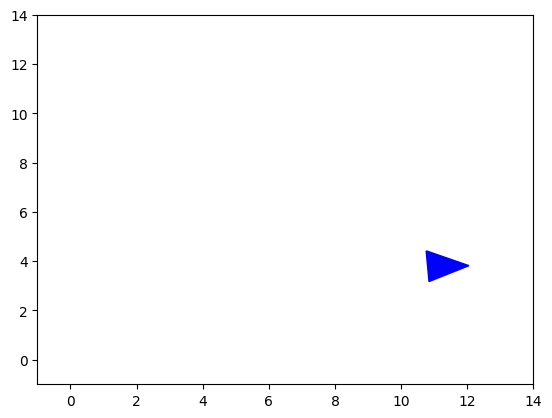

In [196]:
x, y = polygon.exterior.xy
plt.fill(x, y, c="blue")
plt.xlim(-1, xmax)
plt.ylim(-1, ymax)

(-1.0, 10.0)

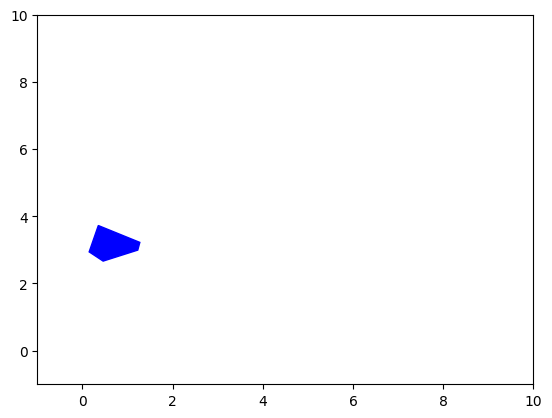

In [211]:
map_bounds = [10, 10]
num_obstacles = 10
shape = 8

xmin, xmax = 0, map_bounds[0]
ymin, ymax = 0, map_bounds[1]


radius = random.uniform(0.05, 0.06)*xmax

center = np.array([np.random.rand()*xmax, np.random.rand()*ymax])

pshape = np.random.randint(3, high=shape)

angles_list = get_angles(pshape)

vertices = get_vertices(center, radius, angles_list)

polygon = Polygon(vertices)

x, y = polygon.exterior.xy
plt.fill(x, y, c="blue")
plt.xlim(-1, xmax)
plt.ylim(-1, ymax)




In [252]:
def generate_polygon_obstacles(map_bounds: tuple, num_obstacles: int, shape: int):
    
    xmin, xmax = 0, map_bounds[0]
    ymin, ymax = 0, map_bounds[1]
    
    min_distance = 1.0
    
    ObstacleList = []
    
    count = 0
    while count < num_obstacles:
        
        radius = random.uniform(0.07, 0.08)*xmax

        center = np.array([np.random.rand()*xmax, np.random.rand()*ymax])

        pshape = np.random.randint(5, high=shape)
        
        angles_list = get_angles(pshape)

        vertices = get_vertices(center, radius, angles_list)

        polygon = Polygon(vertices)
        
        intersects = False
        
        for existing_obstacle in ObstacleList:
            if polygon.intersects(existing_obstacle) or polygon.distance(existing_obstacle) < min_distance:
                intersects = True
                break
                
        if not intersects:
            
        
            ObstacleList.append(polygon)
            count += 1
    
#     fig, ax = plt.subplots()



#     for obstacle in ObstacleList:
#         x,y = obstacle.exterior.xy
#         ax.fill(x, y, color = 'pink')
    
#     ax.set_xlim(-2, xmax+5)
#     ax.set_ylim(-2, ymax+5)

#     # Add labels and title
#     plt.xlabel('X')
#     plt.ylabel('Y')
    return ObstacleList
        
        
    
    

In [253]:
lst = generate_polygon_obstacles(map_bounds, num_obstacles = 15, shape = 9)

In [254]:
lst

[<POLYGON ((5.638 4.653, 4.955 5.212, 4.689 5.17, 4.345 4.909, 4.662 3.821, 5...>,
 <POLYGON ((7.804 7.374, 7.234 7.56, 7.055 7.522, 6.663 7.215, 6.823 6.211, 7...>,
 <POLYGON ((5.78 9.474, 5.658 9.479, 5.099 9.176, 4.991 8.556, 5.449 8.07, 6....>,
 <POLYGON ((9.816 1.749, 9.329 1.921, 8.591 1.341, 8.587 0.987, 9.212 0.401, ...>,
 <POLYGON ((1.038 4.05, 0.557 4.055, 0.015 3.167, 0.167 2.822, 1.52 3.012, 1....>,
 <POLYGON ((4.121 7.099, 3.408 7.411, 2.843 6.993, 3.401 5.948, 3.472 5.941, ...>,
 <POLYGON ((10.452 7.58, 9.428 7.574, 9.248 6.951, 9.371 6.668, 9.681 6.428, ...>,
 <POLYGON ((7.723 3.215, 6.999 3.031, 6.817 2.679, 6.983 2.075, 7.4 1.848, 7....>,
 <POLYGON ((2.302 8.577, 2.107 8.797, 1.07 7.88, 1.108 7.82, 2.276 7.834, 2.3...>,
 <POLYGON ((0.848 1.059, 0.66 1.235, -0.567 0.549, -0.267 -0.041, 1.011 0.578...>,
 <POLYGON ((9.068 10.301, 8.895 10.336, 8.884 10.336, 8.274 10.047, 8.229 9.9...>,
 <POLYGON ((10.117 4.488, 9.573 4.569, 9.553 4.564, 9.001 3.681, 9.241 3.265,...>,
 <PO